# 3.6 Adding parameters to a model

In this tutorial, you will learn how to add additional parameters to a model.

## Problem

We will extend the previous network model with an immune parameter, converting it from an SIR model to an SIS model.

In [ ]:
"""
Simple agent-based SIS model
In this model, agents who have been infected return to the susceptible compartment.
However, they retain some 'memory' of their previous infection.
This memory gives them partial protection against reinfection, which wanes over time.
"""

import numpy as np
import sciris as sc
import pylab as pl


# Set default parameters
default_pars = sc.objdict(
    beta = 0.3, # Infection rate per contact per unit time
    gamma = 0.5, # Recovery rate
    waning_rate = 1.0, # Rate at which immunity wanes
    n_contacts = 10, # Number of people each person is connected to
    distance = 0.1, # The distance over which people form contacts
    I0 = 3, # Number of people initially infected
    N = 1000, # Total population size
    maxtime = 40, # How long to simulate for
    npts = 100, # Number of time points during the simulation
    seed = 1, # Random seed to use
    colors = sc.objdict(S='darkgreen', I='gold', R='skyblue'),
    save_movie = False, # Whether to save the movie (slow)
)

class Person(sc.dictobj):
    """
    Define each person (agent) in SimpleABM

    They have three (mutually exclusive) states: susceptible (S), infected (I),
    recovered (R). They also have x,y coordinates for plotting.
    """

    def __init__(self, pars):
        self.pars = pars
        self.S = True # People start off susceptible
        self.I = False
        self.t_I = None  # Initially no time of infection
        self.imm = 0  # Start with no immunity
        self.x = np.random.rand()
        self.y = np.random.rand()

    def infect(self, t):
        self.S = False
        self.I = True
        self.t_I = t  # Record the time that an infection happens

    def recover(self, t):
        self.I = False
        self.S = True  # They are susceptible again
        self.imm = 1  # Start with perfect immunity
        
    # EXERCISE: write a method "check_immunity" that updates the immunity based on exponential decay for time since infection
    def check_immunity(self, t):

    # EXERCISE: update check_infection to depend on the immunity parameter 
    def check_infection(self, other, t):
        pars = self.pars
        if self.S: # A person must be susceptible to be infected
            if other.I: # The other person must be infectious

    def check_recovery(self, t):
        pars = self.pars
        if self.I: # A person must be infected to recover
            if np.random.rand() < pars.gamma*pars.dt: # Recovery is also probabilistic
                self.recover(t)


class Sim(sc.dictobj):
    """
    Define the simulation
    """

    def __init__(self, **kwargs):
        pars = sc.mergedicts(default_pars, kwargs) # Parameters to use
        pars.dt = pars.maxtime/pars.npts # Timestep length
        self.T = np.arange(pars.npts)
        self.time = self.T*pars.dt
        self.pars = pars
        self.initialize()

    def initialize(self):
        """ Initialize everything (sim can be re-initialized as well) """
        pars = self.pars

        # Initilaize people and the network
        np.random.seed(pars.seed)
        self.people = [Person(pars) for i in range(pars.N)] # Create all the people
        for person in self.people[0:pars.I0]: # Make the first I0 people infectious
            person.infect(t=0) # Set the initial conditions
        self.make_network()

        # Initial conditions
        self.S = np.zeros(pars.npts)
        self.I = np.zeros(pars.npts)
        self.S_full = []
        self.I_full = []

    def get_xy(self):
        """ Get the location of each agent """
        x = np.array([p.x for p in self.people])
        y = np.array([p.y for p in self.people])
        return x,y

    def make_network(self):
        """ Create the network by pairing agents who are close to each other """
        pars = self.pars
        x,y = self.get_xy()
        dist = np.zeros((pars.N, pars.N))
        for i in range(pars.N):
            dist[i,:] = 1 + ((x - x[i])**2 + (y - y[i])**2)**0.5/self.pars.distance
            dist[i,i] = np.inf

        rnds = np.random.rand(pars.N, pars.N)
        ratios = dist/rnds
        order = np.argsort(ratios, axis=None)
        inds = order[0:int(pars.N*pars.n_contacts/2)]
        contacts = np.unravel_index(inds, ratios.shape)
        self.contacts = np.vstack(contacts).T

    def check_infections(self, t):
        """ Check which agents become infected """
        for p1,p2 in self.contacts:
            person1 = self.people[p1]
            person2 = self.people[p2]
            person1.check_infection(person2, t)
            person2.check_infection(person1, t)

    def check_recoveries(self, t):
        """ Check which agents recover """
        for person in self.people:
            person.check_recovery(t)

    # EXERCISE: write a "check_immunities" method
    def check_immunities(self, t):
        """ Check how agent immunity evolves """

    def count(self, t):
        """ Count the number of agents in each state """
        this_S = []
        this_I = []
        for i,person in enumerate(self.people):
            if person.S: this_S.append(i)
            if person.I: this_I.append(i)

        self.S[t] += len(this_S)
        self.I[t] += len(this_I)

        self.S_full.append(this_S)
        self.I_full.append(this_I)

    def run(self):
        """ Run the simulation by integrating over time """
        for t in self.T:
            self.check_infections(t) # Check which infectious occur
            self.check_recoveries(t) # Check which recoveries occur
            self.check_immunities(t) # Check which recoveries occur
            self.count(t) # Store results

    def plot(self):
        """ Plot numbers of S, I, R over time """
        pl.figure()
        cols = self.pars.colors
        pl.plot(self.time, self.S, label='Susceptible', c=cols.S)
        pl.plot(self.time, self.I, label='Infected', c=cols.I)
        pl.legend()
        pl.xlabel('Time')
        pl.ylabel('Number of people')
        pl.ylim(bottom=0)
        pl.xlim(left=0)
        pl.show()


if __name__ == '__main__':

    # Create and run the simulation
    sim = Sim()
    sim.run()
    sim.plot()

## Solution

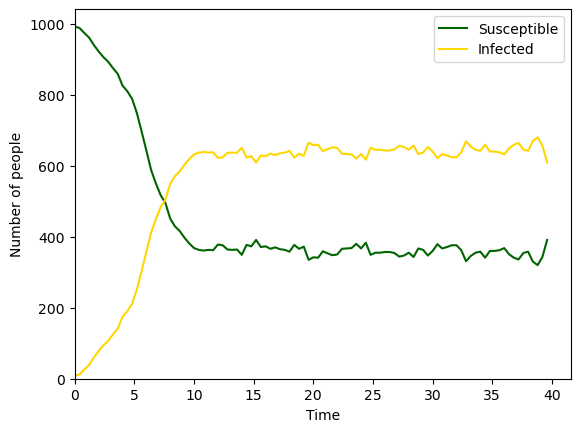

In [1]:
"""
Simple agent-based SIS model
In this model, agents who have been infected return to the susceptible compartment.
However, they retain some 'memory' of their previous infection.
This memory gives them partial protection against reinfection, which wanes over time.
"""

import numpy as np
import sciris as sc
import pylab as pl


# Set default parameters
default_pars = sc.objdict(
    beta = 0.3, # Infection rate per contact per unit time
    gamma = 0.5, # Recovery rate
    waning_rate = 1.0, # Rate at which immunity wanes
    n_contacts = 10, # Number of people each person is connected to
    distance = 0.1, # The distance over which people form contacts
    I0 = 3, # Number of people initially infected
    N = 1000, # Total population size
    maxtime = 40, # How long to simulate for
    npts = 100, # Number of time points during the simulation
    seed = 1, # Random seed to use
    colors = sc.objdict(S='darkgreen', I='gold', R='skyblue'),
    save_movie = False, # Whether to save the movie (slow)
)

class Person(sc.dictobj):
    """
    Define each person (agent) in SimpleABM

    They have three (mutually exclusive) states: susceptible (S), infected (I),
    recovered (R). They also have x,y coordinates for plotting.
    """

    def __init__(self, pars):
        self.pars = pars
        self.S = True # People start off susceptible
        self.I = False
        self.t_I = None  # Initially no time of infection
        self.imm = 0  # Start with no immunity
        self.x = np.random.rand()
        self.y = np.random.rand()

    def infect(self, t):
        self.S = False
        self.I = True
        self.t_I = t  # Record the time that an infection happens

    def recover(self, t):
        self.I = False
        self.S = True  # They are susceptible again
        self.imm = 1  # Start with perfect immunity
        
    # EXERCISE: write a method "check_immunity" that updates the immunity based on exponential decay for time since infection
    def check_immunity(self, t):
        if self.S and self.t_I is not None:
            self.imm = np.exp((self.t_I - t)/self.pars.waning_rate)
        return

    # EXERCISE: update check_infection to depend on the immunity parameter 
    def check_infection(self, other, t):
        pars = self.pars
        if self.S: # A person must be susceptible to be infected
            if other.I: # The other person must be infectious
                if np.random.rand() < pars.beta*pars.dt*(1-self.imm): # Infection is probabilistic
                    self.infect(t)

    def check_recovery(self, t):
        pars = self.pars
        if self.I: # A person must be infected to recover
            if np.random.rand() < pars.gamma*pars.dt: # Recovery is also probabilistic
                self.recover(t)


class Sim(sc.dictobj):
    """
    Define the simulation
    """

    def __init__(self, **kwargs):
        pars = sc.mergedicts(default_pars, kwargs) # Parameters to use
        pars.dt = pars.maxtime/pars.npts # Timestep length
        self.T = np.arange(pars.npts)
        self.time = self.T*pars.dt
        self.pars = pars
        self.initialize()

    def initialize(self):
        """ Initialize everything (sim can be re-initialized as well) """
        pars = self.pars

        # Initilaize people and the network
        np.random.seed(pars.seed)
        self.people = [Person(pars) for i in range(pars.N)] # Create all the people
        for person in self.people[0:pars.I0]: # Make the first I0 people infectious
            person.infect(t=0) # Set the initial conditions
        self.make_network()

        # Initial conditions
        self.S = np.zeros(pars.npts)
        self.I = np.zeros(pars.npts)
        self.S_full = []
        self.I_full = []

    def get_xy(self):
        """ Get the location of each agent """
        x = np.array([p.x for p in self.people])
        y = np.array([p.y for p in self.people])
        return x,y

    def make_network(self):
        """ Create the network by pairing agents who are close to each other """
        pars = self.pars
        x,y = self.get_xy()
        dist = np.zeros((pars.N, pars.N))
        for i in range(pars.N):
            dist[i,:] = 1 + ((x - x[i])**2 + (y - y[i])**2)**0.5/self.pars.distance
            dist[i,i] = np.inf

        rnds = np.random.rand(pars.N, pars.N)
        ratios = dist/rnds
        order = np.argsort(ratios, axis=None)
        inds = order[0:int(pars.N*pars.n_contacts/2)]
        contacts = np.unravel_index(inds, ratios.shape)
        self.contacts = np.vstack(contacts).T

    def check_infections(self, t):
        """ Check which agents become infected """
        for p1,p2 in self.contacts:
            person1 = self.people[p1]
            person2 = self.people[p2]
            person1.check_infection(person2, t)
            person2.check_infection(person1, t)

    def check_recoveries(self, t):
        """ Check which agents recover """
        for person in self.people:
            person.check_recovery(t)

    # EXERCISE: write a "check_immunities" method
    def check_immunities(self, t):
        """ Check how agent immunity evolves """
        for person in self.people:
            person.check_immunity(t)

    def count(self, t):
        """ Count the number of agents in each state """
        this_S = []
        this_I = []
        for i,person in enumerate(self.people):
            if person.S: this_S.append(i)
            if person.I: this_I.append(i)

        self.S[t] += len(this_S)
        self.I[t] += len(this_I)

        self.S_full.append(this_S)
        self.I_full.append(this_I)

    def run(self):
        """ Run the simulation by integrating over time """
        for t in self.T:
            self.check_infections(t) # Check which infectious occur
            self.check_recoveries(t) # Check which recoveries occur
            self.check_immunities(t) # Check which recoveries occur
            self.count(t) # Store results

    def plot(self):
        """ Plot numbers of S, I, R over time """
        pl.figure()
        cols = self.pars.colors
        pl.plot(self.time, self.S, label='Susceptible', c=cols.S)
        pl.plot(self.time, self.I, label='Infected', c=cols.I)
        pl.legend()
        pl.xlabel('Time')
        pl.ylabel('Number of people')
        pl.ylim(bottom=0)
        pl.xlim(left=0)
        pl.show()


if __name__ == '__main__':

    # Create and run the simulation
    sim = Sim()
    sim.run()
    sim.plot()

## Part 2

Add another parameter of your choosing to the model, and test how it affects the results.